<a href="https://colab.research.google.com/github/Mohamed-b2dr/Neural-Network-Project/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Starting Thinking about Data & Distribution of Data**


4600 Datasets images

The data set contains the following diseases:

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


In [ ]:
splitfolders.ratio("drive/MyDrive/Data/Dataset", output="drive/MyDrive/Data/cancer/output", ratio=(.5, .5))

In [ ]:
data_dir_train = pathlib.Path( 'drive/MyDrive/Data/cancer/output/Train/')
img_height,  img_width  = 224, 224

In [ ]:
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width))

Found 2245 files belonging to 9 classes.


In [ ]:
class_names = train_ds.class_names

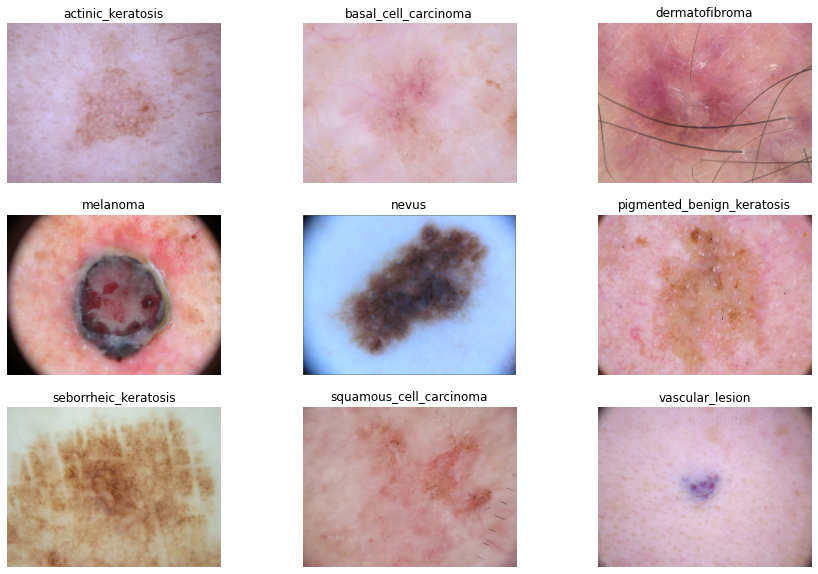

In [ ]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic_keratosis': 114,
 'basal_cell_carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 444,
 'nevus': 357,
 'pigmented_benign_keratosis': 462,
 'seborrheic_keratosis': 77,
 'squamous_cell_carcinoma': 181,
 'vascular_lesion': 139}

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic_keratosis,114
basal_cell_carcinoma,376
dermatofibroma,95
melanoma,444
nevus,357
pigmented_benign_keratosis,462
seborrheic_keratosis,77
squamous_cell_carcinoma,181
vascular_lesion,139


#**Rectify the class imbalance**


Python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples

Instantiate a Pipeline object pointing to a directory containing your initial image data set.

Define a number of operations to perform on this data set using your Pipeline object.

Execute these operations by calling the Pipeline’s sample() method.


###**Main Feature of our work**


*   Perspective Skewing
*   Elastic Distortions
*   Cropping
*   Mirroring
*   Rotating
*   Shearing



In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
path_to_training_dataset = 'drive/MyDrive/Data/cancer/train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory='drive/MyDrive/Data/cancer/output/train/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

##**Bulid our model**

In [ ]:
batch_size = 32
epochs = 500
img_size = 224

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('drive/MyDrive/Data/cancer/output/train/',
                                                 target_size=(224,224),
                                                 batch_size=32)

test_set = test_datagen.flow_from_directory('drive/MyDrive/Data/cancer/output/val/',
                                            target_size=(224,224),
                                            batch_size=32,
                                            shuffle=False)

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [ ]:
def InceptionResNetV2_model():

    engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (img_size , img_size , 3),

    )
    

    x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
    x =Dropout(0.75)(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                      beta_regularizer=None,
                      gamma_regularizer=None,
                      beta_constraint=None,
                      gamma_constraint=None,

                  )(x)

    out = tf.keras.layers.Dense(9, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model

    model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

    model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

    return model

In [ ]:
"""
def InceptionResNetV2_model():

    engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (img_size , img_size , 3),

    )

    x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
    out = tf.keras.layers.Dense(11, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model

    model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

    model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4),
        #optimizer= SGD(lr=3e-4, momentum=0.9),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.sparse_categorical_crossentropy,
        loss = tf.keras.losses.CategoricalCrossentropy(),
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

    return model
"""

"\ndef InceptionResNetV2_model():\n\n    engine = tf.keras.applications.Xception(\n        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model\n        include_top = False,\n\n        # Use Imagenet weights\n        weights = 'imagenet',\n\n        # Define input shape to 224x224x3\n        input_shape = (img_size , img_size , 3),\n\n    )\n\n    x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)\n    out = tf.keras.layers.Dense(11, activation = 'softmax', name = 'dense_output')(x)\n\n\n    # Build the Keras model\n\n    model = tf.keras.models.Model(inputs = engine.input, outputs = out)\n    # Compile the model\n\n    model.compile(\n        # Set optimizer to Adam(0.0001)\n        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4),\n        #optimizer= SGD(lr=3e-4, momentum=0.9),\n        # Set loss to binary crossentropy\n        #loss = tf.keras.losses.sparse_categorical_crossentropy,\n        loss = tf.keras.losses.C

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
filepath = 'drive/MyDrive/Models/mymodel-best.ckpt'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [ ]:
 def train():
    time_start = time.time()
    
    model = InceptionResNetV2_model()
    
    model.summary()
    history = model.fit(training_set, epochs= 500 ,validation_data = test_set,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction, checkpoint ]
                        )
    
    

    model.save_weights('drive/MyDrive/Models/wCancer.h5')
    model.save('drive/MyDrive/Models/Cancer.h5')
    
    print('Model saved.')
    
    time_end = time.time()
    print('Training Time:', time_end - time_start)
    print('\n')

    return history

In [ ]:
def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod =  keras.models.load_model('drive/MyDrive/Models/Skin Cancer/Cancer.h5')
    mod.evaluate(test_set)
    
    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1) 


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [ ]:
input_path = 'drive/MyDrive/Data/cancer/output/val/'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(224, 224))

Found 1800 files belonging to 9 classes.


In [ ]:
if __name__ == "__main__":
  
    key = train_data.class_names
    train_history = train() 
    prob, predIdxs, model= test()
    

Testing:
57/57 [==============================] - 583s 10s/step - loss: 0.1653 - accuracy: 0.9472


                            precision    recall  f1-score   support

         actinic keratosis    0.82700   0.98000   0.89703       200
      basal cell carcinoma    0.97512   0.98000   0.97756       200
            dermatofibroma    0.99502   1.00000   0.99751       200
                  melanoma    0.97590   0.81000   0.88525       200
                     nevus    0.95758   0.79000   0.86575       200
pigmented benign keratosis    0.97938   0.95000   0.96447       200
      seborrheic keratosis    0.84615   0.99000   0.91244       200
   squamous cell carcinoma    0.99010   1.00000   0.99502       200
           vascular lesion    1.00000   1.00000   1.00000       200

                  accuracy                        0.94444      1800
                 macro avg    0.94959   0.94444   0.94389      1800
              weighted avg    0.94959   0.94444   0.94389      1800



# **Final Test & Evaluation**

In [ ]:
input_path = 'drive/MyDrive/Data/cancer/Test/'
test = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(224, 224))
 key = test.class_names

Found 2239 files belonging to 9 classes.


In [ ]:
test = test_datagen.flow_from_directory('drive/MyDrive/Data/cancer/Test/',
                                            target_size=(224,224),
                                            batch_size=32,
                                            shuffle=False)

Found 2239 images belonging to 9 classes.


In [ ]:
model.evaluate(test)

70/70 [==============================] - 646s 9s/step - loss: 0.2784 - accuracy: 0.9080


[0.2784214913845062, 0.9079946279525757]

In [ ]:
prob = model.predict(test)
predIdxs = np.argmax(prob, axis=1) 
print('\n')
print(classification_report(test.labels, predIdxs,target_names = key, digits=5))



                            precision    recall  f1-score   support

         actinic keratosis    0.59043   0.97368   0.73510       114
      basal cell carcinoma    0.99196   0.98404   0.98798       376
            dermatofibroma    0.95960   1.00000   0.97938        95
                  melanoma    0.97500   0.80137   0.87970       438
                     nevus    0.94863   0.77591   0.85362       357
pigmented benign keratosis    0.99323   0.95238   0.97238       462
      seborrheic keratosis    0.49045   1.00000   0.65812        77
   squamous cell carcinoma    0.95745   0.99448   0.97561       181
           vascular lesion    1.00000   1.00000   1.00000       139

                  accuracy                        0.91112      2239
                 macro avg    0.87853   0.94243   0.89354      2239
              weighted avg    0.94064   0.91112   0.91732      2239



**Noticed for Accuracy**

actinic keratosis &  seborrheic keratosis Very bad, using  confusion_matrix to know the prolem with this classes and anthor classes



##**Implementation confusion_matrix**


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
cm = confusion_matrix(test.labels, predIdxs)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = key, 
                     columns =key)

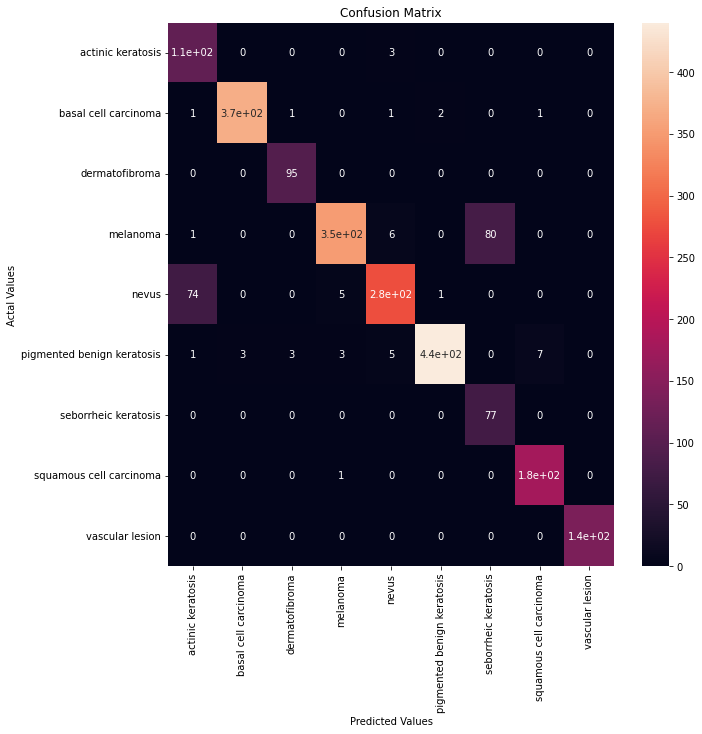

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


**We Noticed, Model not good t0 difference between:**
 

*   Actinic & Nevus
*   seborrheic keratosis & melanoma


Our Future plan working around data to slove this problem:

some preprocessing in data to solve this conflict.
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

Another solution, make our system consist of two layers and merge Actinic & Nevus in one category and seborrheic keratosis & melanoma in one category, and layer two have two models of binary classification if the result is one of the merged categories, the disadvantage will resources usages









## **Save Arc Model & labelling clases**

In [ ]:
category = 'drive/MyDrive/Models/Skin Cancer/Atopic Dermatitis.json'
import json
aDict ={}
for i in range(len(key)):
    aDict[key[i]] = i
jsonFile = open(category, "w")
jsonString = json.dumps(aDict)
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('drive/MyDrive/Models/Skin Cancer/Cancer_Arch.json', 'w') as json_file:
    json_file.write(json_model)